# Question 2

## (a) Design an auto encoder to take in MNIST images with latent space dimension of 2,16,256. 

- Train auto encoder with L1-norm reconstruction loss 

- Do a 2D plot of the latent space for different digits for latent space of 2D. 

- K-means clustering for latent space of dimensions 16,256. 

- Use one color for each digit. 

- Report all results. 
- What do you notice about the reconstructed images? 

In [6]:
%%capture
!pip install umap-learn
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.manifold import TSNE
import umap.umap_ as umap
from torchsummary import summary
from skimage import filters

In [7]:
# https://avandekleut.github.io/vae/
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [8]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = torch.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [10]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = (abs(x - x_hat)).sum()  #L1 norm
            loss.backward()
            opt.step()
    return autoencoder

In [11]:
def plot_latent(autoencoder, data, num_batches=100):
    z_val = []
    for i, (x, y) in enumerate(data):
        # z = torch.flatten(x, start_dim=1)
        # z = autoencoder.encoder.linear1(z)
        # z = autoencoder.encoder.linear2(z)
        z = autoencoder.encoder(x)
        z = z.detach().numpy()
        z_val.append(zip(z,y))
        if i > num_batches:
            #return z_val
            break

    # z_val = plot_latent(autoencoder, data, num_batches=100)
    X_mat, y_act = [], []
    for i in z_val:
      for a, b in i:
        X_mat.append(a)
        y_act.append(b.item())
    
    # T-SNE transformation
    X_mat_TSNE = TSNE(n_components=2).fit_transform(X_mat)

    # plot actual results
    plt.figure()
    plt.scatter(X_mat_TSNE[:, 0], 
                X_mat_TSNE[:, 1], 
                s=.1, c=y_act, cmap='tab10')
    plt.title('actual')
    plt.show()

    return X_mat_TSNE

def plot_latent_kmeans(X_mat_TSNE):
    # k-means clustering
    kmeans = KMeans(n_clusters=10)
    kmeans.fit(X_mat_TSNE)
    y_kmeans = kmeans.predict(X_mat_TSNE)
    # plot k-means results
    plt.figure()
    plt.scatter(X_mat_TSNE[:, 0], 
                X_mat_TSNE[:, 1], 
                s=.1, c=y_kmeans, cmap='tab10')
    plt.title('K-means')
    plt.show()

In [12]:
def plot_latent_umap(autoencoder, data, num_batches=100):
    z_val = []
    for i, (x, y) in enumerate(data):
        # z = torch.flatten(x, start_dim=1)
        # z = autoencoder.encoder.linear1(z)
        # z = autoencoder.encoder.linear2(z)
        z = autoencoder.encoder(x)
        z = z.detach().numpy()
        z_val.append(zip(z,y))
        if i > num_batches:
            #return z_val
            break

    # z_val = plot_latent(autoencoder, data, num_batches=100)
    X_mat, y_act = [], []
    for i in z_val:
      for a, b in i:
        X_mat.append(a)
        y_act.append(b.item())
    
    # UMAP transformation
    X_mat_UMAP = umap.UMAP().fit_transform(X_mat)

    # plot actual results
    plt.figure()
    plt.scatter(X_mat_UMAP[:, 0], 
                X_mat_UMAP[:, 1], 
                s=.1, c=y_act, cmap='tab10')
    plt.title('actual')
    plt.show()

    return X_mat_UMAP

def plot_latent_umap_kmeans(X_mat_UMAP):
    # k-means clustering
    kmeans = KMeans(n_clusters=10)
    kmeans.fit(X_mat_UMAP)
    y_kmeans = kmeans.predict(X_mat_UMAP)
    # plot k-means results
    plt.figure()
    plt.scatter(X_mat_UMAP[:, 0], 
                X_mat_UMAP[:, 1], 
                s=.1, c=y_kmeans, cmap='tab10')
    plt.title('K-means')
    plt.show()

In [13]:
def plot_reconstructed(autoencoder, latent_vectors):
    w = 28
    n = 12
    img = np.zeros((n*w, n*w))
    for i in range(n):
        for j in range(n):
            z = torch.Tensor(latent_vectors[i*n+j].tolist())
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[-5,10, -5, 10])

latent_vectors_2 = np.random.uniform(-5, 10,[1444,2])
latent_vectors_16 =  np.random.uniform(-5, 10,[144,16])
latent_vectors_256 =  np.random.uniform(-5, 10,[144,256])

### dim = 2

In [9]:
autoencoder_2 = Autoencoder(2)
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True),
        batch_size=128,
        shuffle=True)
autoencoder_2 = train(autoencoder_2, data)

In [10]:
autoencoder_2

Autoencoder(
  (encoder): Encoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=2, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=784, bias=True)
  )
)

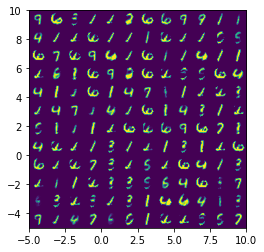

In [12]:
plot_reconstructed(autoencoder_2, latent_vectors_2)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


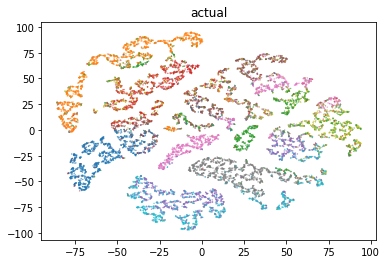

In [13]:
X_mat_TSNE_2 = plot_latent(autoencoder_2, data, num_batches=100)

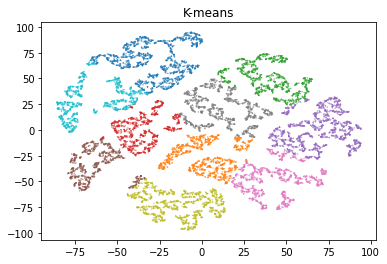

In [14]:
plot_latent_kmeans(X_mat_TSNE_2)

### dim = 16

In [16]:
autoencoder_16 = Autoencoder(16)
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True),
        batch_size=128,
        shuffle=True)
autoencoder_16 = train(autoencoder_16, data)

In [17]:
autoencoder_16

Autoencoder(
  (encoder): Encoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=16, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=784, bias=True)
  )
)

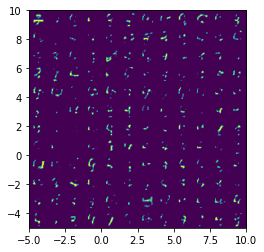

In [18]:
plot_reconstructed(autoencoder_16, latent_vectors_16)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


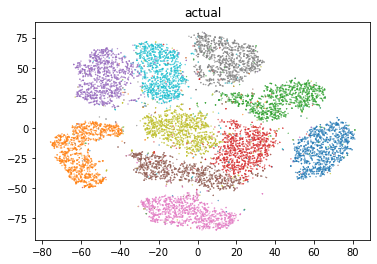

In [19]:
X_mat_TSNE_16 = plot_latent(autoencoder_16, data, num_batches=100)

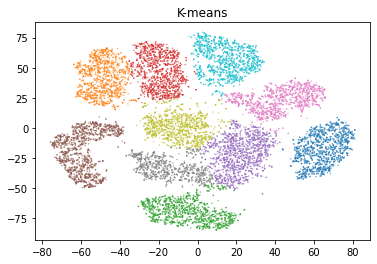

In [20]:
plot_latent_kmeans(X_mat_TSNE_16)

### dim = 256

In [22]:
autoencoder_256 = Autoencoder(256)
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True),
        batch_size=128,
        shuffle=True)
autoencoder_256 = train(autoencoder_256, data)

In [23]:
autoencoder_256

Autoencoder(
  (encoder): Encoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=256, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=784, bias=True)
  )
)

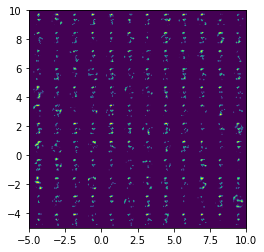

In [24]:
plot_reconstructed(autoencoder_256, latent_vectors_256)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


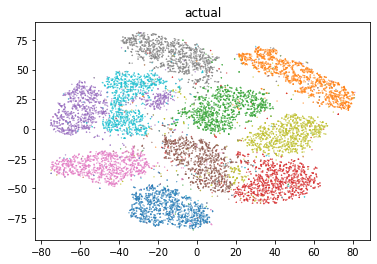

In [25]:
X_mat_TSNE_256 = plot_latent(autoencoder_256, data, num_batches=100)

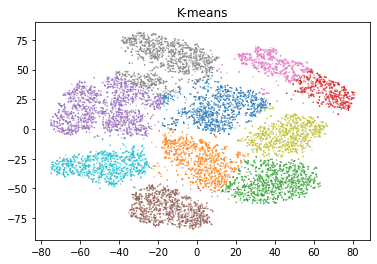

In [26]:
plot_latent_kmeans(X_mat_TSNE_256)

## (b) Design another neural network “dis_net” to discriminate between blur images and clear images. Blur images can be generated by taking the original MNIST data and do some gaussian blur.
Train auto encoder with L1-norm reconstruction loss + discriminator loss. Make reconstructed images as clear as possible, that is, the auto encoder will need to be trained so that “dis_net” score it as a clear image
Compare results between (a) and (b)

In [14]:
# define dis_net
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 1)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        x = torch.sigmoid(self.linear3(x))
        return x

In [15]:
def add_gaussian(images,sigma=1.0):
    blurred_images = np.zeros(images.shape)
    for i in range(images.shape[0]):
        blurred_images[i,0] = blurred = filters.gaussian(
    images[i], sigma=(sigma, sigma), truncate=3.5, multichannel=True)
    
    return blurred_images

In [16]:
# https://discuss.pytorch.org/t/using-a-combined-loss-to-update-two-different-models/73925/2
import pandas as pd

def train_ae_dis(autoencoder, discriminator, data, epochs=100):
    ae_opt = torch.optim.Adam(autoencoder.parameters())
    dis_opt =  torch.optim.Adam(discriminator.parameters()) 

    dis_losses = []
    losses = []

    for epoch in range(epochs):
        print("training epoch", epoch+1)
        losses_sum = 0
        dis_losses_sum = 0

        for x, y in data:
            ae_opt.zero_grad()
            dis_opt.zero_grad()
            
            # train discriminator
            x_numpy = x.detach().numpy()
            blur_x = add_gaussian(x_numpy) 
            dis_x = np.concatenate([x_numpy,blur_x], axis =0)
            dis_y_one = np.ones([x.shape[0],1])
            dis_y_zero = np.zeros([x.shape[0],1])
            dis_y_target = np.concatenate([dis_y_one, dis_y_zero])
            dis_y_pred = discriminator(torch.from_numpy(dis_x).float())
        
            dis_loss = nn.BCELoss()(dis_y_pred, torch.from_numpy(dis_y_target).float())
            dis_loss.backward()
            dis_opt.step()
            
            #train ae
            x_hat = autoencoder(x)
            x_hat_pred = discriminator(x_hat)
            dis_loss = nn.BCELoss()(x_hat_pred, torch.from_numpy(np.ones([x_hat.shape[0],1])).float())
            
            # combine two losses
            loss = (abs(x - x_hat)).sum() + dis_loss  #L1 norm + dis_loss
            loss.backward()
            ae_opt.step()

    # plot losses

            losses_sum += loss.item()
            dis_losses_sum += dis_loss.item()
        
        losses.append(losses_sum)
        dis_losses.append(dis_losses_sum)
        print('loss: ', losses_sum)
        print('dis_loss: ', dis_losses_sum)

    pd.DataFrame({
        #'loss': losses,
        'dis_net loss': dis_losses
    }).plot()
    
    return autoencoder

training epoch 1
loss:  5567639.897949219
dis_loss:  33.379193408065476
training epoch 2
loss:  4967760.0830078125
dis_loss:  44.741746676154435
training epoch 3
loss:  4828652.9755859375
dis_loss:  25.05438440234866
training epoch 4
loss:  4748495.438964844
dis_loss:  29.285810029134154
training epoch 5
loss:  4694809.810058594
dis_loss:  30.94932288012933
training epoch 6
loss:  4651841.312011719
dis_loss:  23.930906949259224
training epoch 7
loss:  4620575.492675781
dis_loss:  28.150111843715422
training epoch 8
loss:  4592872.37890625
dis_loss:  37.86318016669247
training epoch 9
loss:  4562019.8994140625
dis_loss:  42.916811573901214
training epoch 10
loss:  4534806.196777344
dis_loss:  32.37999518495053
training epoch 11
loss:  4501586.189941406
dis_loss:  66.58918546303175
training epoch 12
loss:  4472326.165527344
dis_loss:  56.56301130933571
training epoch 13
loss:  4453086.09375
dis_loss:  40.75899482151726
training epoch 14
loss:  4437227.95703125
dis_loss:  60.6544207972765

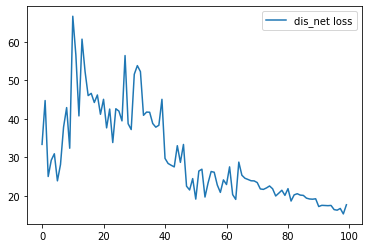

In [17]:
autoencoder_2 = Autoencoder(2)
discriminator = Discriminator()
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True),
        batch_size=128,
        shuffle=True)
autoencoder_2 = train_ae_dis(autoencoder_2, discriminator, data)

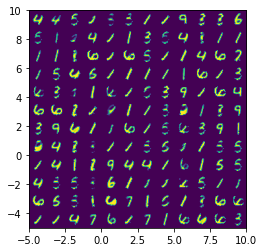

In [18]:
plot_reconstructed(autoencoder_2, latent_vectors_2)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


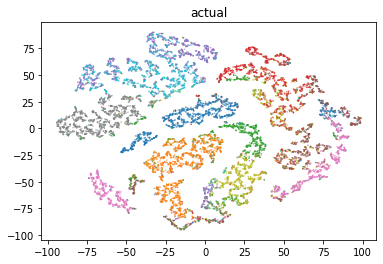

In [19]:
X_mat_TSNE_2 = plot_latent(autoencoder_2, data, num_batches=100)

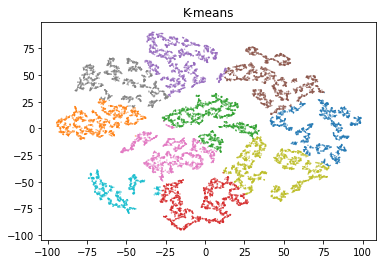

In [20]:
plot_latent_kmeans(X_mat_TSNE_2)

training epoch 1
loss:  5054933.560546875
dis_loss:  19.299091812950792
training epoch 2
loss:  3291473.7734375
dis_loss:  3.218247668802178
training epoch 3
loss:  2657512.6318359375
dis_loss:  3.5019681440094246
training epoch 4
loss:  2345889.215576172
dis_loss:  3.3475577457038526
training epoch 5
loss:  2162260.530029297
dis_loss:  3.951757990470128
training epoch 6
loss:  2046598.0051269531
dis_loss:  3.1476575449397615
training epoch 7
loss:  1935922.2307128906
dis_loss:  3.3390997363283086
training epoch 8
loss:  1883556.2709960938
dis_loss:  3.063403965505387
training epoch 9
loss:  1839915.763671875
dis_loss:  2.897309222726207
training epoch 10
loss:  1801115.0903320312
dis_loss:  3.2525560918219254
training epoch 11
loss:  1764705.3586425781
dis_loss:  3.030863569001909
training epoch 12
loss:  1727004.837890625
dis_loss:  2.344247059390689
training epoch 13
loss:  1698328.9953613281
dis_loss:  2.808829323405643
training epoch 14
loss:  1673449.0122070312
dis_loss:  2.61910

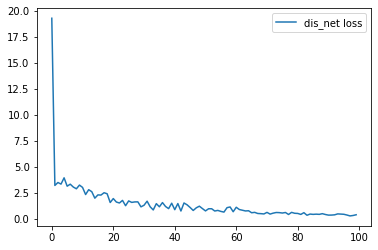

In [21]:
autoencoder_16 = Autoencoder(16)
discriminator = Discriminator()
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True),
        batch_size=128,
        shuffle=True)
autoencoder_16 = train_ae_dis(autoencoder_16, discriminator, data)

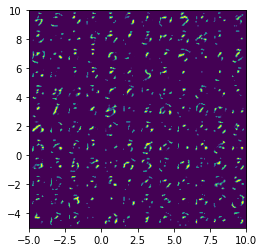

In [22]:
plot_reconstructed(autoencoder_16, latent_vectors_16)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


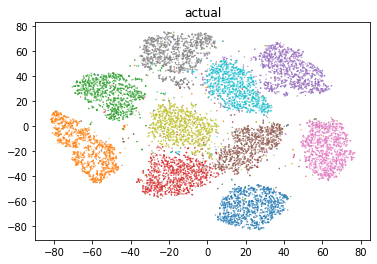

In [23]:
X_mat_TSNE_16 = plot_latent(autoencoder_16, data, num_batches=100)

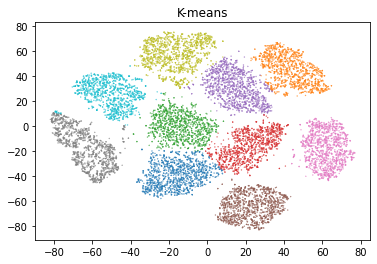

In [24]:
plot_latent_kmeans(X_mat_TSNE_16)

training epoch 1
loss:  6298483.5244140625
dis_loss:  12.959627614734927
training epoch 2
loss:  6128045.5693359375
dis_loss:  0.6437078165836283
training epoch 3
loss:  6132792.890625
dis_loss:  0.15996861558051023
training epoch 4
loss:  6135212.796875
dis_loss:  0.2810652099633444
training epoch 5
loss:  6137274.40234375
dis_loss:  0.9402464045924717
training epoch 6
loss:  6137273.7216796875
dis_loss:  0.3843071763394619
training epoch 7
loss:  6137273.5380859375
dis_loss:  0.38475995311637234
training epoch 8
loss:  6137261.796875
dis_loss:  0.05724686200028373
training epoch 9
loss:  6172518.5888671875
dis_loss:  6.76117036976575
training epoch 10
loss:  5930833.5185546875
dis_loss:  0.9713136037043917
training epoch 11
loss:  3296118.5810546875
dis_loss:  5.039523938125392
training epoch 12
loss:  2033629.4187011719
dis_loss:  2.1918768502300017
training epoch 13
loss:  1822003.923828125
dis_loss:  1.4829484778070405
training epoch 14
loss:  1726722.5925292969
dis_loss:  1.49591

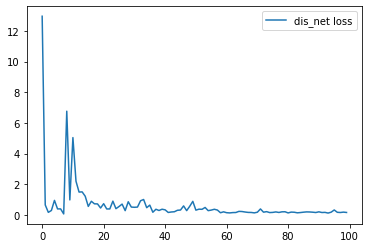

In [25]:
autoencoder_256 = Autoencoder(256)
discriminator = Discriminator()
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True),
        batch_size=128,
        shuffle=True)
autoencoder_256 = train_ae_dis(autoencoder_256, discriminator, data)

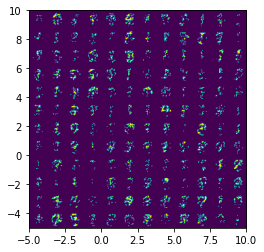

In [26]:
plot_reconstructed(autoencoder_256, latent_vectors_256)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


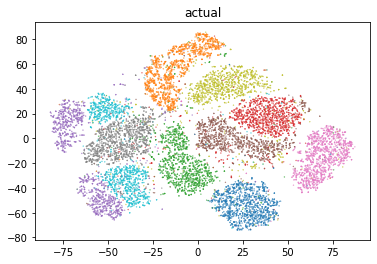

In [27]:
X_mat_TSNE_256 = plot_latent(autoencoder_256, data, num_batches=100)

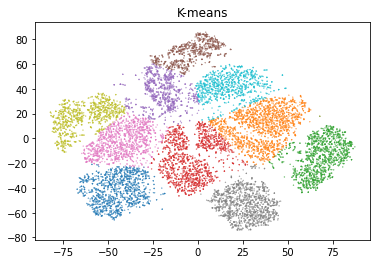

In [38]:
plot_latent_kmeans(X_mat_TSNE_256)